**Sources : https://github.com/Bhavin789/Twitter-Airline-Sentiment-Analysis/blob/master/Air%20Line%20Twitter%20Sentiment%20Analysis.ipynb 

https://scikit-learn.org/dev/auto_examples/model_selection/grid_search_text_feature_extraction.html https://www.kaggle.com/jiashenliu/how-can-we-predict-the-sentiment-by-tweets

https://medium.com/analytics-vidhya/twitter-sentiment-analysis-b9a12dbb2043

https://colab.research.google.com/drive/1e1lRkOAqwmlPDsUaJ5uxzE-wU_Dty0fw

In [508]:
import numpy as np
import pandas as pd
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer

**Load Dataset

In [509]:
# load dataset
# your code here
data = pd.read_csv(r'E:\Semester Three UTD\NLP\Homework1\train.csv',encoding='latin1')
data.head()

,Id,text,Target
0,1,@USAirways ! THE WORST in customer service. @...,-1
1,2,@united call wait times are over 20 minutes an...,-1
2,3,@JetBlue what's up with the random delay on fl...,-1
3,4,@AmericanAir Good morning! Wondering why my p...,0
4,5,@united UA 746. Pacific Rim and Date Night cut...,-1


**Sentiment distribution

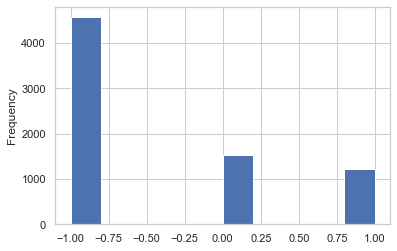

In [510]:
data['Target'].plot(kind='hist')
plt.show()

**Train Data Preprocessing

**Modifying the list of stop words

In [511]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))
print(len(stopwords.words('english')))
remove_from_stopwords = ["couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "needn't", "shan't" "shouldn't", "wasn't", "weren't", "won't", "wouldn't",'not',"who", "what", "when", "why", "how", "which", "where", "whom", "no", "not"]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Negative words should be retained as they explain negative sentiments.

In [512]:
stop_words = set(stopwords.words('english')) - set(["who", "what", "when", "why", "how", "which", "where", "whom", "no", "not", "weren't", "aren't","didn't", "wasn't", "couldn't", "hadn't","hasn't", "doesn't", "shouldn't", "isn't", "wouldn't", "don't", "mightn't", "won't", "haven't", "mustn", "ain","hasn", "weren", "mustn't", "wasn", "didn", "hadn", "don", "haven", "shouldn", "shan't", "isn", "wouldn", "mightn", "couldn", "needn't", "doesn"])
print("\nList of stopwords in English:")
print (stop_words)
print (len(stop_words))


List of stopwords in English:
{'once', 'few', 'shan', 'then', 'but', 'were', 'into', 'against', 'all', 'these', 'between', 'now', 'did', "she's", 'am', 'be', 'she', 'have', 'theirs', 'through', 'at', 'hers', 'they', 'as', 'doing', 'has', 'won', 'very', 'my', "you'll", 'by', 'over', 'its', 'an', 'your', "that'll", 'me', 'there', 'any', 'their', 'do', 'them', 'that', 've', "you're", 'i', 'you', 'him', 'own', 'll', 'will', 'such', 'again', 'm', 'are', 'some', 'if', 'up', 'while', 'he', 'the', 'most', 'themselves', 'only', 'd', 'we', 'her', 'and', 'itself', 'both', 'should', 'of', 'myself', 'a', 'or', 'those', 'aren', 'further', 'yours', 'because', 'below', 'to', 'just', "you'd", 'than', 'his', 'is', 'yourself', 'ma', 'about', 'other', 'on', 'y', 'himself', 't', 'above', "you've", 'needn', 'ours', 'been', 'ourselves', 'down', 'having', 'each', 'can', 'was', 'our', 're', 'from', 'so', 'with', 'o', "it's", 'more', 'in', 'it', 'same', 'out', 'under', 'after', 'until', 'for', 'yourselves', 'h

In [513]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stop_words]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

data['text']=data['text'].map(lambda s:preprocess(s)) 

In [514]:

class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        #finding all the substring containing the pattern in the tweet
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #all the alphanumeric character
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: self.count_regex(r'https?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        data = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return data

In [515]:
from sklearn.feature_extraction.text import CountVectorizer

tc = TextCounts()

data_eda = tc.fit_transform(data.text)
data_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,11,0,0,0,0,0,0
1,9,0,0,0,0,0,0
2,8,0,0,0,0,0,0
3,12,0,0,0,0,0,0
4,12,0,0,0,0,0,0


In [516]:
data_eda['Target'] = data.Target
data_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,Target
0,11,0,0,0,0,0,0,-1
1,9,0,0,0,0,0,0,-1
2,8,0,0,0,0,0,0,-1
3,12,0,0,0,0,0,0,0
4,12,0,0,0,0,0,0,-1


In [517]:
data.groupby('Target').mean()

,Id
Target,
-1,3651.866404
0,3685.492188
1,3661.348112


In [518]:
data_eda.groupby('Target').mean()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
Target,,,,,,,
-1,10.949190,0.0,0.0,0.0,0.0,0.0,0.0
0,7.985026,0.0,0.0,0.0,0.0,0.0,0.0
1,8.188013,0.0,0.0,0.0,0.0,0.0,0.0


**Cleaning the text- tried both Porter and Snowball stemming

In [519]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()

    def stemming(self, input_text):
        porter = PorterStemmer()
        #stemmer2 = SnowballStemmer(language='english')
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.stemming)
        return clean_X

In [520]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
ct = CleanText()
sr_clean = ct.fit_transform(data.text)
sr_clean.sample(5)
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


In [521]:
i=1
empty_clean = sr_clean == ''


print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'
print (sr_clean[0:5])

0 records have no words left after text cleaning
0    usairway worst custom servic usairway call mon...
1    unit call wait time minut airport wait time lo...
2     jetblu what random delay flight chanc fals alarm
3    americanair good morn wonder whi pre tsa check...
4    unit pacif rim date night cut not constantli r...
Name: text, dtype: object


In [522]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
#printing only first 50
cv.get_feature_names()[0:50]
#bow.sum(axis=0)

#from sklearn.feature_extraction.text import HashingVectorizer
#hv = HashingVectorizer()
#bow = hv.fit_transform(sr_clean)
#hv.get_feature_names()[0:20]

['aadvantag',
 'aafail',
 'aaso',
 'abandon',
 'abassinet',
 'abc',
 'abcnetwork',
 'abcnew',
 'abi',
 'abigailedg',
 'abil',
 'abl',
 'aboard',
 'aboout',
 'abound',
 'abq',
 'absolut',
 'absoulut',
 'absurd',
 'absurdli',
 'abt',
 'abus',
 'abysm',
 'acc',
 'acceler',
 'accept',
 'access',
 'accid',
 'accident',
 'accomid',
 'accommod',
 'accompani',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accountâ',
 'acct',
 'accur',
 'achiev',
 'aci',
 'ack',
 'acknowledg',
 'acosta',
 'acpt',
 'acquir',
 'across',
 'act',
 'actingoutmgmnt',
 'action']

In [523]:
data_model = data_eda
data_model['clean_text'] = sr_clean
data_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'Target',
 'clean_text']

In [524]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        #print("I am in")
        
        #print(X[self.cols].dtype())
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

**Splitting the train data

In [525]:
X_train, X_test, y_train, y_test = train_test_split(data_model.drop('Target', axis=1), data_model.Target, test_size=0.30, random_state=0)

**Defining gridsearch and vectorization used MacroF as scoring criteria

In [526]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        print("not good")
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        print("ok")
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_s = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=6,scoring='f1_macro')
    grid_s.fit(X_train, y_train)
    

    print("Best CV score: %0.3f" % grid_s.best_score_)
    print("Best parameters set:")
    best_parameters = grid_s.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_s.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Train score with best_estimator_: %0.3f" % grid_s.best_estimator_.score(X_train, y_train))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_s.best_estimator_.predict(X_test)))
    print("Classification Report Train Data")
    print(classification_report(y_train, grid_s.best_estimator_.predict(X_train)))                    
    return grid_s

In [531]:
# Parameters for the vectorizers
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2,3,4)
}


# Parameters for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75,1,1.25)
}


# Parameters for LogisticRegression
parameters_logreg = {
    
    'clf__C': (1.05, 1.10, 1.15,1.20,1.25),
    'clf__penalty': ('l1', 'l2'),
    'clf__multi_class': ['auto'],
    #'clf_solver':['liblinear']
}

# Parameter grid settings for XGBoost 
parameters_xgboost = {
    #'clf__min_child_weight': (1,5,10),
    'clf__gamma': (0.5,1,1.5,2),
}

# Parameter grid settings for BernoulliNB
parameters_bnb = {
    'clf__alpha': [1],
}

**Using four Algorithms - Multinomial NB,Bernoulli NB,Logistic and XGboost

In [532]:
from sklearn.naive_bayes import BernoulliNB
mnb = MultinomialNB()
logreg = LogisticRegression()
xgboost = XGBClassifier()
Bnb = BernoulliNB()

**Executing models with Countvectorization

In [533]:
countvect = CountVectorizer()
#Hashvect = HashingVectorizer()

**Multinomial Naive Bayes with CountVectorization

In [466]:
mnb_cv = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Fitting 6 folds for each of 120 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   44.2s finished


Best CV score: 0.682
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 4
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.760


Train score with best_estimator_: 0.846


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.84      0.86      0.85      1414
           0       0.55      0.48      0.51       437
           1       0.65      0.70      0.67       345

    accuracy                           0.76      2196
   macro avg       0.68      0.68      0.68      2196
weighted avg       0.75      0.76      0.76      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.90      0.89      0.90      3152
           0       0.74      0.70      0.72      1099
           1       0.80      0.86      0.83       873

    accuracy                           0.85      5124
   macro avg       0.81      

**Bernoulli Naive Bayes with CountVectorization

In [558]:
Bnb_cv = grid_vect(Bnb, parameters_bnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   11.3s finished


Best CV score: 0.711
Best parameters set:
	clf__alpha: 1
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 4
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.783


Train score with best_estimator_: 0.841


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.87      0.87      0.87      1414
           0       0.57      0.57      0.57       437
           1       0.68      0.69      0.68       345

    accuracy                           0.78      2196
   macro avg       0.71      0.71      0.71      2196
weighted avg       0.78      0.78      0.78      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.90      0.89      0.89      3152
           0       0.71      0.72      0.71      1099
           1       0.80      0.82      0.81       873

    accuracy                           0.84      5124
   macro avg       0.80      0

**Logistic Regression with CountVectorization

In [534]:
logreg_cv = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Fitting 6 folds for each of 240 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.8min finished
C:\Users\Krishna\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best CV score: 0.714
Best parameters set:
	clf__C: 1.15
	clf__multi_class: 'auto'
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.783


Train score with best_estimator_: 0.904


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.84      0.90      0.87      1414
           0       0.60      0.49      0.54       437
           1       0.72      0.67      0.69       345

    accuracy                           0.78      2196
   macro avg       0.72      0.69      0.70      2196
weighted avg       0.77      0.78      0.78      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.92      0.97      0.94      3152
           0       0.86      0.77      0.81      1099
           1       0.90      0.85      0.88       873

    accuracy                           0

**XGboost with CountVectorization

In [469]:
xgboost_cv = grid_vect(xgboost, parameters_xgboost, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Fitting 6 folds for each of 96 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 25.5min finished


Best CV score: 0.694
Best parameters set:
	clf__gamma: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.782


Train score with best_estimator_: 0.872


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.82      0.92      0.87      1414
           0       0.62      0.48      0.54       437
           1       0.75      0.62      0.68       345

    accuracy                           0.78      2196
   macro avg       0.73      0.67      0.70      2196
weighted avg       0.77      0.78      0.77      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.89      0.95      0.92      3152
           0       0.80      0.71      0.75      1099
           1       0.91      0.79      0.84       873

    accuracy                           0.87      5124
   macro avg       0.86     

**Multinomial Using Tf-IDF Vectorizer

In [363]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvect = TfidfVectorizer()
multinomialnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Fitting 6 folds for each of 120 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   43.4s finished


Best CV score: 0.624
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 4
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.760


Train score with best_estimator_: 0.830


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.77      0.97      0.86      1414
           0       0.64      0.27      0.38       437
           1       0.79      0.54      0.64       345

    accuracy                           0.76      2196
   macro avg       0.73      0.59      0.62      2196
weighted avg       0.75      0.76      0.73      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.81      0.98      0.89      3152
           0       0.85      0.52      0.65      1099
           1       0.90      0.69      0.78       873

    accuracy                           0.83      5124
   macro avg       0.86    

**Bernoulli Naive Bayes Using Tf-IDF Vectorizer

In [376]:
Bnb_tfidf = grid_vect(Bnb, parameters_bnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   10.6s finished


Best CV score: 0.705
Best parameters set:
	clf__alpha: 1
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 4
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.774


Train score with best_estimator_: 0.844


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.89      0.84      0.86      1414
           0       0.55      0.63      0.58       437
           1       0.67      0.68      0.67       345

    accuracy                           0.77      2196
   macro avg       0.70      0.72      0.71      2196
weighted avg       0.78      0.77      0.78      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.92      0.87      0.90      3152
           0       0.69      0.80      0.74      1099
           1       0.80      0.81      0.80       873

    accuracy                           0.84      5124
   macro avg       0.80      0

**Logistic Using Tf-IDF Vectorizer

In [553]:
logisticreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Fitting 6 folds for each of 240 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.3min finished
C:\Users\Krishna\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best CV score: 0.683
Best parameters set:
	clf__C: 1.25
	clf__multi_class: 'auto'
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 4
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.788


Train score with best_estimator_: 0.819


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.82      0.93      0.87      1414
           0       0.66      0.44      0.53       437
           1       0.76      0.63      0.69       345

    accuracy                           0.79      2196
   macro avg       0.75      0.67      0.70      2196
weighted avg       0.78      0.79      0.77      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.83      0.95      0.88      3152
           0       0.76      0.55      0.64      1099
           1       0.84      0.69      0.76       873

    accuracy                           0

**Xgboost Using Tf-IDF Vectorizer

In [367]:
xgboost_tfidf = grid_vect(xgboost, parameters_xgboost, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Fitting 6 folds for each of 96 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 39.8min finished


Best CV score: 0.685
Best parameters set:
	clf__gamma: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.765


Train score with best_estimator_: 0.899


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.81      0.90      0.85      1414
           0       0.59      0.46      0.52       437
           1       0.71      0.62      0.66       345

    accuracy                           0.77      2196
   macro avg       0.71      0.66      0.68      2196
weighted avg       0.75      0.77      0.76      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.91      0.96      0.94      3152
           0       0.83      0.79      0.81      1099
           1       0.93      0.82      0.87       873

    accuracy                           0.90      5124
   macro avg       0.89     

**Executing Models with Hash Vectorization

**Logistic Regression with Hash Vectorization

In [377]:
# Parameters for the vectorizers
parameters_vect = {
    #'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    #'features__pipe__vect__min_df': (1,2,3,4)
}


# Parameters for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75,1,1.25)
}


# Parameters for LogisticRegression
parameters_logreg = {
    
    'clf__C': (1.05, 1.10, 1.15,1.20,1.25),
    'clf__penalty': ('l1', 'l2'),
    'clf__multi_class': ['auto']
}

# Parameter grid settings for XGBoost 
parameters_xgboost = {
    #'clf__min_child_weight': (1,5,10),
    'clf__gamma': (0.5,1,1.5,2),
}

# Parameter grid settings for BernoulliNB
parameters_bnb = {
    'clf__alpha': [1],
}

In [378]:
Hashvect = HashingVectorizer()

In [317]:
logisticreg_hv = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=Hashvect)

ok
Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.8min finished
C:\Users\Krishna\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best CV score: 0.668
Best parameters set:
	clf__C: 1.2
	clf__multi_class: 'auto'
	clf__penalty: 'l1'
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.782


Train score with best_estimator_: 0.795


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.82      0.92      0.87      1414
           0       0.63      0.45      0.52       437
           1       0.75      0.62      0.68       345

    accuracy                           0.78      2196
   macro avg       0.73      0.66      0.69      2196
weighted avg       0.77      0.78      0.77      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.81      0.94      0.87      3152
           0       0.70      0.49      0.58      1099
           1       0.80      0.66      0.72       873

    accuracy                           0.80      5124
   macro avg       0.77      0.70      0.73      5124
w

In [ ]:
mnb_hv = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=Hashvect)

**Did not execute as parameters mismatch

In [ ]:
xgboost_hv = grid_vect(xgboost, parameters_xgboost, X_train, X_test, parameters_text=parameters_vect, vect=Hashvect)

**Did not execute as parameters mismatch

**Bernoulli Naive Bayes with HashVectorization

In [379]:
Bnb_hv = grid_vect(Bnb, parameters_bnb, X_train, X_test, parameters_text=parameters_vect, vect=Hashvect)

ok
Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.3s finished


Best CV score: 0.254
Best parameters set:
	clf__alpha: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.644


Train score with best_estimator_: 0.615


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.64      1.00      0.78      1414
           0       0.00      0.00      0.00       437
           1       0.00      0.00      0.00       345

    accuracy                           0.64      2196
   macro avg       0.21      0.33      0.26      2196
weighted avg       0.41      0.64      0.50      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.62      1.00      0.76      3152
           0       0.00      0.00      0.00      1099
           1       0.00      0.00      0.00       873

    accuracy                           0.62      5124
   macro avg       0.21      0.33      0.25      5124
weighted avg       0.38      0.62      0.47  

C:\Users\Krishna\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Reading Test Data and Preprocessing it

In [535]:
# load test dataset
test = pd.read_csv(r'E:\Semester Three UTD\NLP\Homework1\test.csv',encoding='latin1')


In [536]:
test.head()

,id,text
0,7322,@AmericanAir In car gng to DFW. Pulled over 1h...
1,7323,"@AmericanAir after all, the plane didnÂÃÂªt ..."
2,7324,@SouthwestAir can't believe how many paying cu...
3,7325,@USAirways I can legitimately say that I would...
4,7326,@AmericanAir still no response from AA. great ...


**Modifying the list of stop words

In [537]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))
print(len(stopwords.words('english')))
remove_from_stopwords = ["couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "needn't", "shan't" "shouldn't", "wasn't", "weren't", "won't", "wouldn't",'not',"who", "what", "when", "why", "how", "which", "where", "whom", "no", "not"]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [538]:
stop_words = set(stopwords.words('english')) - set(["who", "what", "when", "why", "how", "which", "where", "whom", "no", "not", "weren't", "aren't","didn't", "wasn't", "couldn't", "hadn't","hasn't", "doesn't", "shouldn't", "isn't", "wouldn't", "don't", "mightn't", "won't", "haven't", "mustn", "ain","hasn", "weren", "mustn't", "wasn", "didn", "hadn", "don", "haven", "shouldn", "shan't", "isn", "wouldn", "mightn", "couldn", "needn't", "doesn"])
print("\nList of stopwords in English:")
print (stop_words)
print (len(stop_words))


List of stopwords in English:
{'once', 'few', 'shan', 'then', 'but', 'were', 'into', 'against', 'all', 'these', 'between', 'now', 'did', "she's", 'am', 'be', 'she', 'have', 'theirs', 'through', 'at', 'hers', 'they', 'as', 'doing', 'has', 'won', 'very', 'my', "you'll", 'by', 'over', 'its', 'an', 'your', "that'll", 'me', 'there', 'any', 'their', 'do', 'them', 'that', 've', "you're", 'i', 'you', 'him', 'own', 'll', 'will', 'such', 'again', 'm', 'are', 'some', 'if', 'up', 'while', 'he', 'the', 'most', 'themselves', 'only', 'd', 'we', 'her', 'and', 'itself', 'both', 'should', 'of', 'myself', 'a', 'or', 'those', 'aren', 'further', 'yours', 'because', 'below', 'to', 'just', "you'd", 'than', 'his', 'is', 'yourself', 'ma', 'about', 'other', 'on', 'y', 'himself', 't', 'above', "you've", 'needn', 'ours', 'been', 'ourselves', 'down', 'having', 'each', 'can', 'was', 'our', 're', 'from', 'so', 'with', 'o', "it's", 'more', 'in', 'it', 'same', 'out', 'under', 'after', 'until', 'for', 'yourselves', 'h

In [539]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stop_words]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

test['text']=test['text'].map(lambda s:preprocess(s)) 

In [540]:
test.head()

,id,text
0,7322,americanair car gng dfw pulled ago icy roads h...
1,7323,americanair plane didnâ âªt land identical wor...
2,7324,southwestair believe how many paying customers...
3,7325,usairways legitimately say would rather driven...
4,7326,americanair still response great job guys


In [541]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [542]:

class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        #finding all the substring containing the pattern in the tweet
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #all the alphanumeric character
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: self.count_regex(r'https?://[^\s]+[\s]?', x))
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        data = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return data

In [543]:
from sklearn.feature_extraction.text import CountVectorizer

tc = TextCounts()

test_eda = tc.fit_transform(test.text)
test_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,13,0,0,0,0,0,0
1,11,0,0,0,0,0,0
2,16,0,0,0,0,0,0
3,10,0,0,0,0,0,0
4,6,0,0,0,0,0,0


In [544]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower() 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.stemming)
        return clean_X

In [545]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
ct = CleanText()
sr_clean = ct.fit_transform(test.text)
sr_clean.sample(5)
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


In [547]:
i=1
empty_clean = sr_clean == ''


print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'
print (sr_clean[0:5])

0 records have no words left after text cleaning
0    americanair car gng dfw pull ago ici road hold...
1    americanair plane didnâ âªt land ident wors co...
2    southwestair believ how mani pay custom left h...
3    usairway legitim say would rather driven cross...
4              americanair still respons great job guy
Name: text, dtype: object


In [548]:
data_test = test_eda
data_test['clean_text'] = sr_clean
data_test.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'clean_text']

In [549]:
cv = CountVectorizer()
bow = cv.fit_transform(data_test.clean_text)
bow = cv.transform(data_test.clean_text)
#printing only first 20
cv.get_feature_names()[0:50]
#bow.sum(axis=0)

#from sklearn.feature_extraction.text import HashingVectorizer
#hv = HashingVectorizer()
#bow = hv.fit_transform(sr_clean)
#hv.get_feature_names()[0:20]

['aaaand',
 'aaadvantag',
 'aaalwaysl',
 'aacustomerservic',
 'aadavantag',
 'aadelay',
 'aadv',
 'aadvantag',
 'aafail',
 'aal',
 'aaron',
 'aarp',
 'aateam',
 'aback',
 'abandon',
 'abbrev',
 'abc',
 'abcletjetbluestreamfe',
 'abcnetwork',
 'abcnewsbayarea',
 'abcwtvd',
 'abduct',
 'abi',
 'abil',
 'abl',
 'aboard',
 'abq',
 'abroad',
 'absolut',
 'absorb',
 'absurd',
 'abt',
 'abund',
 'abus',
 'abysm',
 'acarl',
 'acc',
 'accept',
 'access',
 'accid',
 'accident',
 'accommod',
 'accompani',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accountâ',
 'accru',
 'acct']

In [550]:
data_test

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,clean_text
0,13,0,0,0,0,0,0,americanair car gng dfw pull ago ici road hold...
1,11,0,0,0,0,0,0,americanair plane didnâ âªt land ident wors co...
2,16,0,0,0,0,0,0,southwestair believ how mani pay custom left h...
3,10,0,0,0,0,0,0,usairway legitim say would rather driven cross...
4,6,0,0,0,0,0,0,americanair still respons great job guy
5,11,0,0,0,0,0,0,unit develop fli tmrw morn min layov earlier f...
6,3,0,0,0,0,0,0,usairway hello anyon
7,16,0,0,0,0,0,0,usairway husainhaqqani husain shld protest wel...
8,10,0,0,0,0,0,0,usairway not like flightawar say plane still d...
9,13,0,0,0,0,0,0,americanair don even give option hold say line...


**Best model to be used for Prediction - logistic with Count Vectorization

In [554]:
tweet_predict_labels = logreg_cv.predict(data_test)

In [555]:
# Create predictions to be submitted!
pd.DataFrame({'Id': test.id, 'Target': tweet_predict_labels}).to_csv('solution_base_logregtfidf4.csv', index =False)  
print("Done :D")

Done :D


In [556]:
from sklearn.metrics import accuracy_score
accuracy_score(data.Target, tweet_predict_labels)

0.498224043715847

In [557]:
from sklearn import metrics
f1_macro = metrics.f1_score(data.Target, tweet_predict_labels, average="macro")
print ("f1_macro:", f1_macro)

f1_macro: 0.32479812529404684
